In [1]:
import tensorflow as tf
import data_format as df
import numpy as np
import time
data = np.load('origin_data.npy')
noise_dim = 3000
BUFFER_SIZE = 60000
BATCH_SIZE = 128
pre_train = False
if(pre_train): 
    try:
        noises = np.load('noise_pre.npy')
    except:
        print("makeing_noise")
        noises=tf.random.normal([data.shape[0], noise_dim])
        np.save('noise_pre', noises)
else:
    try:
        noises = np.load('noise_n.npy')
    except:
        print("makeing_noise")
        noises = tf.random.normal([data.shape[0], noise_dim])
        np.save('noise_n', noises)
dataset = tf.data.Dataset.from_tensor_slices((data, noises)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
data.shape

(10723, 5245)

In [2]:
dense_dim = data.shape[-1]

In [3]:
def b_g():
    inp = tf.keras.Input((noise_dim,))
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer11")(inp)
    x1 = tf.keras.layers.Dense(dense_dim/8, name="layer12")(x1)
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer13")(x1)
    x1 = tf.keras.layers.BatchNormalization(name="bn11")(x1)
    x2 = tf.keras.layers.Dense(dense_dim/4, name="layer14")(inp)
    x2 = tf.keras.layers.BatchNormalization(name="bn12")(x2)   
    x = 0.5*x1 + 0.5*x2
    
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer21")(x)
    x1 = tf.keras.layers.Dense(dense_dim/8, name="layer22")(x1)
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer23")(x1)
    x1 = tf.keras.layers.BatchNormalization(name="bn21")(x1)
    x2 = tf.keras.layers.Dense(dense_dim/4, name="layer24")(x)
    x2 = tf.keras.layers.BatchNormalization(name="bn22")(x2)    
    x = 0.5*x1 + 0.5*x2
    
    x1 = tf.keras.layers.Dense(dense_dim/2, name="layer31")(x)
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer32")(x1)
    x1 = tf.keras.layers.Dense(dense_dim/2, name="layer33")(x1)
    x1 = tf.keras.layers.BatchNormalization(name="bn31")(x1)
    x2 = tf.keras.layers.Dense(dense_dim/2, name="layer34")(x)
    x2 = tf.keras.layers.BatchNormalization(name="bn32")(x2)   
    x = 0.5*x1 + 0.5*x2
    
    x1 = tf.keras.layers.Dense(dense_dim/2, name="layer41")(x)
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer42")(x1)
    x1 = tf.keras.layers.Dense(dense_dim/2, name="layer43")(x1)
    x1 = tf.keras.layers.BatchNormalization(name="bn41")(x1)
    x2 = tf.keras.layers.Dense(dense_dim/2, name="layer44")(x)
    x2 = tf.keras.layers.BatchNormalization(name="bn42")(x2)   
    x = 0.5*x1 + 0.5*x2
    
    x1 = tf.keras.layers.Dense(data.shape[-1], name="layer51")(x)
    x1 = tf.keras.layers.Dense(data.shape[-1]/2, name="layer52")(x1)
    x1 = tf.keras.layers.Dense(data.shape[-1], name="layer53")(x1) 
    x1 = tf.keras.layers.BatchNormalization(name="bn51")(x1)
    x2 = tf.keras.layers.Dense(data.shape[-1], name="layer54")(x)
    x2 = tf.keras.layers.BatchNormalization(name="bn52")(x2)      
    x = 0.5*x1 + 0.5*x2
    
    x = tf.keras.layers.Attention(name="att1")([x,x])
    o = tf.nn.sigmoid(x)
    
    return tf.keras.Model(inputs=[inp], outputs=[o])
generator = b_g()
try:
    generator.load_weights("gen_pretrain1.h5", by_name=True)
except:
    print("erro loading g")
noise = tf.random.normal([1, noise_dim])
print(generator(noise, training=False))

tf.Tensor([[0.18432112 0.2425701  0.18584079 ... 0.00818724 0.1273391  0.02285218]], shape=(1, 5245), dtype=float32)


In [4]:
def b_d():
    inp = tf.keras.Input(shape=(data.shape[-1],))
    x = tf.keras.layers.Attention(name="att")([inp, inp])
    
    x1 = tf.keras.layers.Dense(dense_dim, name="layer11")(x)  
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer12")(x1)
    x1 = tf.keras.layers.Dense(dense_dim, name="layer13")(x1)   
    x2 = tf.keras.layers.Dense(dense_dim, name="layer14")(x)
    x = 0.5*x1 + 0.5*x2
    
    x1 = tf.keras.layers.Dense(dense_dim/2, name="layer21")(x)
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer22")(x1)
    x1 = tf.keras.layers.Dense(dense_dim/2, name="layer23")(x1)   
    x2 = tf.keras.layers.Dense(dense_dim/2, name="layer24")(x)
    x = 0.5*x1 + 0.5*x2
    
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer31")(x)
    x1 = tf.keras.layers.Dense(dense_dim/8, name="layer32")(x1)
    x1 = tf.keras.layers.Dense(dense_dim/4, name="layer33")(x1)
    x2 = tf.keras.layers.Dense(dense_dim/4, name="layer34")(x) 
    x = 0.5*x1 + 0.5*x2
    
    o = tf.keras.layers.Dense(1, name="layero")(x)
    return tf.keras.Model(inputs=[inp], outputs=[o])
discriminator=b_d()
try:
    discriminator.load_weights("disc_pretrain1.h5")
except:
    print("erro loading d")
print(discriminator(generator(noise, training=False),training=False))

tf.Tensor([[-279.9279]], shape=(1, 1), dtype=float32)


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_output))
    fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_output))
    loss = real_loss + fake_loss
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer_low = tf.keras.optimizers.Adam(1e-8)
discriminator_optimizer_high = tf.keras.optimizers.SGD(1e-4)

In [7]:
@tf.function
def train_step_g(images,noise):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return gen_loss

In [8]:
@tf.function
def train_step_all(images,noise,disc_opt):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss , disc_loss

def train(dataset, epochs ,lenght = 10 ,loss_range = 3):
    best_model_loss = []
    loss_history = []
    for epoch in range(epochs):
        st=time.time()
        opt = discriminator_optimizer_low
        for i,noise in dataset:
            _ = train_step_g(i,noise)
            gen_loss,disc_loss=train_step_all(i,noise,opt)
        disc_loss_ = float(disc_loss)
        gen_loss_  = float(gen_loss)
        if(len(loss_history) < lenght):
            loss_history.append(disc_loss_)
        else:
            tmp = 0
            for i in range(1,len(loss_history)):
                tmp += abs(loss_history[i-1] - loss_history[i])
            if(tmp <= loss_range):
                print("disc lr = 1e-4")
                opt = discriminator_optimizer_high
                loss_history = []
            else:
                print("disc lr = 1e-8")
                opt = discriminator_optimizer_low
                loss_history = []
        if(best_model_loss == [] or abs(best_model_loss[0]/best_model_loss[1]*disc_loss_) >= abs(gen_loss_)):
            best_model_loss = [gen_loss_, disc_loss_]
            generator.save_weights("gen_pretrain_out3.h5")
            discriminator.save_weights("disc_pretrain_out3.h5")
            print("epoch ", epoch, " time:", time.time() - st)                           best_score")
        else:
            print("epoch ", epoch, " time:", time.time() - st)
        print("gen_loss:", float(gen_loss), " disc_loss:", float(disc_loss))

In [9]:
epochs = 5000
train(dataset, epochs)

epoch  0  time: 23.127838373184204                            best_score
gen_loss: 1.1357834339141846  disc_loss: 3.8331122398376465
epoch  1  time: 14.828429698944092
gen_loss: 1.4497863054275513  disc_loss: 4.270541667938232
epoch  2  time: 14.797937154769897
gen_loss: 19.341646194458008  disc_loss: 3.836235284805298
epoch  3  time: 14.802379608154297
gen_loss: 3.2183878421783447  disc_loss: 3.992353677749634
epoch  4  time: 14.810564756393433
gen_loss: 11.261078834533691  disc_loss: 3.7136335372924805
epoch  5  time: 14.802596092224121
gen_loss: 3.1219594478607178  disc_loss: 4.053488254547119
epoch  6  time: 14.807326793670654
gen_loss: 27.759592056274414  disc_loss: 3.7432615756988525
epoch  7  time: 14.800755023956299
gen_loss: 12.247364044189453  disc_loss: 4.343594074249268
epoch  8  time: 14.803098917007446
gen_loss: 3.529006242752075  disc_loss: 2.9827122688293457
epoch  9  time: 17.761858701705933                            best_score
gen_loss: 0.8745754361152649  disc_loss:

epoch  84  time: 14.79391598701477
gen_loss: -4.392228126525879  disc_loss: 8.15770149230957
epoch  85  time: 14.820683002471924
gen_loss: -5.386406898498535  disc_loss: 8.974875450134277
epoch  86  time: 14.801608562469482
gen_loss: -4.8677167892456055  disc_loss: 8.363621711730957
disc lr = 1e-8
epoch  87  time: 14.806676387786865
gen_loss: -6.191640377044678  disc_loss: 9.500646591186523
epoch  88  time: 14.797496795654297
gen_loss: -5.39168643951416  disc_loss: 9.274284362792969
epoch  89  time: 14.792928695678711
gen_loss: -6.129889488220215  disc_loss: 9.477081298828125
epoch  90  time: 14.798335790634155
gen_loss: -5.4920806884765625  disc_loss: 9.28930950164795
epoch  91  time: 14.801289558410645
gen_loss: -3.4217610359191895  disc_loss: 7.125534534454346
epoch  92  time: 14.785746335983276
gen_loss: -5.905895709991455  disc_loss: 10.125689506530762
epoch  93  time: 14.812623739242554
gen_loss: -6.023306846618652  disc_loss: 9.433732986450195
epoch  94  time: 14.800544023513794

epoch  168  time: 14.808536291122437
gen_loss: 1.3523589372634888  disc_loss: 2.9333064556121826
epoch  169  time: 14.789589881896973
gen_loss: 0.8093550801277161  disc_loss: 3.221219778060913
epoch  170  time: 14.789317607879639
gen_loss: 1.047230839729309  disc_loss: 2.602013111114502
epoch  171  time: 14.788926362991333
gen_loss: 0.7150151133537292  disc_loss: 3.1578361988067627
epoch  172  time: 14.803443670272827
gen_loss: 1.5092246532440186  disc_loss: 2.5510528087615967
epoch  173  time: 14.805309772491455
gen_loss: 0.7389097809791565  disc_loss: 2.709463596343994
epoch  174  time: 14.809798955917358
gen_loss: 0.6881420016288757  disc_loss: 3.3131468296051025
disc lr = 1e-8
epoch  175  time: 14.802998781204224
gen_loss: 0.5245919227600098  disc_loss: 3.2060537338256836
epoch  176  time: 14.800334930419922
gen_loss: 1.4496382474899292  disc_loss: 2.483534336090088
epoch  177  time: 14.803641319274902
gen_loss: 0.1702180653810501  disc_loss: 3.490560531616211
epoch  178  time: 14.

disc lr = 1e-4
epoch  252  time: 14.811654090881348
gen_loss: 1.8224550485610962  disc_loss: 3.292510509490967
epoch  253  time: 14.804383277893066
gen_loss: -0.10066394507884979  disc_loss: 3.2112812995910645
epoch  254  time: 14.801512241363525
gen_loss: -0.3332461714744568  disc_loss: 3.7400989532470703
epoch  255  time: 14.789848566055298
gen_loss: -0.26667362451553345  disc_loss: 3.4774131774902344
epoch  256  time: 14.79072618484497
gen_loss: -0.23531270027160645  disc_loss: 3.5455617904663086
epoch  257  time: 14.801424026489258
gen_loss: -0.17200379073619843  disc_loss: 3.5694236755371094
epoch  258  time: 14.807191133499146
gen_loss: 0.01496966928243637  disc_loss: 3.405871868133545
epoch  259  time: 14.796758890151978
gen_loss: 0.05929003283381462  disc_loss: 3.3539721965789795
epoch  260  time: 14.793160438537598
gen_loss: -0.06099918112158775  disc_loss: 3.026763439178467
epoch  261  time: 14.8058602809906
gen_loss: 0.106956347823143  disc_loss: 2.9998514652252197
epoch  26

epoch  335  time: 14.790413856506348
gen_loss: 0.13106641173362732  disc_loss: 2.8213508129119873
epoch  336  time: 14.79776644706726
gen_loss: 0.11791878193616867  disc_loss: 2.921145439147949
epoch  337  time: 14.811468362808228
gen_loss: 0.09478701651096344  disc_loss: 2.7317075729370117
epoch  338  time: 14.802803039550781
gen_loss: 0.12920454144477844  disc_loss: 2.763597249984741
epoch  339  time: 14.801437854766846
gen_loss: 0.17330992221832275  disc_loss: 2.6920480728149414
disc lr = 1e-4
epoch  340  time: 14.806456327438354
gen_loss: 0.09532704949378967  disc_loss: 3.0883352756500244
epoch  341  time: 14.80195426940918
gen_loss: 0.06703450530767441  disc_loss: 3.0700266361236572
epoch  342  time: 14.80491018295288
gen_loss: 0.08887741714715958  disc_loss: 3.001133918762207
epoch  343  time: 14.78665542602539
gen_loss: 0.10741095244884491  disc_loss: 2.8566677570343018
epoch  344  time: 14.80822205543518
gen_loss: 0.12791404128074646  disc_loss: 2.742358684539795
epoch  345  ti

epoch  419  time: 14.803424835205078
gen_loss: -0.18771211802959442  disc_loss: 2.6341357231140137
epoch  420  time: 14.816828727722168
gen_loss: -0.1972469687461853  disc_loss: 2.58077073097229
epoch  421  time: 14.806514739990234
gen_loss: -0.2918722927570343  disc_loss: 2.82338285446167
epoch  422  time: 14.802280902862549
gen_loss: -0.48040157556533813  disc_loss: 2.8277499675750732
epoch  423  time: 14.803216695785522
gen_loss: -0.5659400224685669  disc_loss: 3.067168712615967
epoch  424  time: 14.806453466415405
gen_loss: -0.551974356174469  disc_loss: 3.019204616546631
epoch  425  time: 14.815921545028687
gen_loss: -0.5555007457733154  disc_loss: 2.9777116775512695
epoch  426  time: 14.794608354568481
gen_loss: -0.506435751914978  disc_loss: 3.0253586769104004
epoch  427  time: 14.802823781967163
gen_loss: -0.48738861083984375  disc_loss: 2.904174327850342
disc lr = 1e-4
epoch  428  time: 14.787923336029053
gen_loss: -0.5101754665374756  disc_loss: 3.012509822845459
epoch  429  

epoch  503  time: 14.81028938293457
gen_loss: -0.2922561764717102  disc_loss: 2.7430548667907715
epoch  504  time: 14.8158540725708
gen_loss: -0.3120194971561432  disc_loss: 2.7372326850891113
disc lr = 1e-4
epoch  505  time: 14.81117582321167
gen_loss: -0.3018793761730194  disc_loss: 2.709831714630127
epoch  506  time: 14.80817985534668
gen_loss: -0.19430194795131683  disc_loss: 2.5769991874694824
epoch  507  time: 14.80098295211792
gen_loss: -0.2854907214641571  disc_loss: 2.66823148727417
epoch  508  time: 14.796446800231934
gen_loss: -0.3640795350074768  disc_loss: 2.7467353343963623
epoch  509  time: 14.792481899261475
gen_loss: -0.3584204316139221  disc_loss: 2.727972984313965
epoch  510  time: 14.793076753616333
gen_loss: -0.24094955623149872  disc_loss: 2.4883270263671875
epoch  511  time: 14.794039011001587
gen_loss: -0.30607926845550537  disc_loss: 2.6276469230651855
epoch  512  time: 14.793075323104858
gen_loss: 0.07471626996994019  disc_loss: 2.2005367279052734
epoch  513  

epoch  586  time: 14.822977542877197
gen_loss: -0.3647567927837372  disc_loss: 2.4199113845825195
epoch  587  time: 14.827735662460327
gen_loss: -0.4331546723842621  disc_loss: 2.6155457496643066
epoch  588  time: 14.812096118927002
gen_loss: -0.3913825750350952  disc_loss: 2.5841012001037598
epoch  589  time: 14.823307991027832
gen_loss: -0.35800543427467346  disc_loss: 2.476263999938965
epoch  590  time: 14.805891036987305
gen_loss: -0.25304102897644043  disc_loss: 2.4068238735198975
epoch  591  time: 14.828121185302734
gen_loss: -0.37175044417381287  disc_loss: 2.5157408714294434
epoch  592  time: 14.814335584640503
gen_loss: -0.25696420669555664  disc_loss: 2.423281669616699
disc lr = 1e-4
epoch  593  time: 14.820385694503784
gen_loss: -0.30393877625465393  disc_loss: 2.4368748664855957
epoch  594  time: 14.823269367218018
gen_loss: 3.374643564224243  disc_loss: 2.3881351947784424
epoch  595  time: 14.823683500289917
gen_loss: -0.3285951018333435  disc_loss: 2.602081775665283
epoch

epoch  669  time: 14.811901092529297
gen_loss: -0.29685312509536743  disc_loss: 2.360680103302002
disc lr = 1e-4
epoch  670  time: 14.822307109832764
gen_loss: -0.29609307646751404  disc_loss: 2.4050984382629395
epoch  671  time: 14.819266080856323
gen_loss: -0.21898460388183594  disc_loss: 2.240842580795288
epoch  672  time: 14.81288766860962
gen_loss: -0.21581891179084778  disc_loss: 2.284318208694458
epoch  673  time: 14.820858001708984
gen_loss: -0.19970813393592834  disc_loss: 2.2311253547668457
epoch  674  time: 14.819515943527222
gen_loss: -0.2636176347732544  disc_loss: 2.3214797973632812
epoch  675  time: 14.819001913070679
gen_loss: -0.29332607984542847  disc_loss: 2.4109978675842285
epoch  676  time: 14.821308135986328
gen_loss: -0.24705640971660614  disc_loss: 2.2890262603759766
epoch  677  time: 14.83031678199768
gen_loss: -0.27129465341567993  disc_loss: 2.296491861343384
epoch  678  time: 14.80898141860962
gen_loss: -0.22882361710071564  disc_loss: 2.203310966491699
epoc

epoch  752  time: 14.816928625106812
gen_loss: -1.1184672117233276  disc_loss: 3.0369272232055664
epoch  753  time: 14.838777542114258
gen_loss: -1.0097391605377197  disc_loss: 3.00282883644104
epoch  754  time: 14.81893539428711
gen_loss: -1.0039381980895996  disc_loss: 2.992922782897949
epoch  755  time: 14.799579381942749
gen_loss: -0.9766791462898254  disc_loss: 2.9042611122131348
epoch  756  time: 14.818765878677368
gen_loss: -0.9749324917793274  disc_loss: 3.014024257659912
epoch  757  time: 14.812398672103882
gen_loss: -0.965083122253418  disc_loss: 2.9265191555023193
disc lr = 1e-4
epoch  758  time: 14.806904792785645
gen_loss: -0.9094187617301941  disc_loss: 2.828033924102783
epoch  759  time: 14.824150562286377
gen_loss: -0.86179119348526  disc_loss: 2.793332099914551
epoch  760  time: 14.815362215042114
gen_loss: -0.7993987202644348  disc_loss: 2.786561965942383
epoch  761  time: 14.818961143493652
gen_loss: -0.8060068488121033  disc_loss: 2.8109073638916016
epoch  762  time

epoch  836  time: 14.832444906234741
gen_loss: -0.356535404920578  disc_loss: 2.197007417678833
epoch  837  time: 14.806025266647339
gen_loss: -0.3414217233657837  disc_loss: 2.162693500518799
epoch  838  time: 14.82769775390625
gen_loss: -0.3275059163570404  disc_loss: 2.1336727142333984
epoch  839  time: 14.810153722763062
gen_loss: -0.3133055865764618  disc_loss: 2.1256775856018066
epoch  840  time: 14.826842069625854
gen_loss: -0.3846568167209625  disc_loss: 2.183255195617676
epoch  841  time: 14.828635215759277
gen_loss: -0.4286276400089264  disc_loss: 2.2889699935913086
epoch  842  time: 14.827967882156372
gen_loss: -0.43452557921409607  disc_loss: 2.224915027618408
epoch  843  time: 14.8189857006073
gen_loss: -0.4272681772708893  disc_loss: 2.181293249130249
epoch  844  time: 14.825550556182861
gen_loss: -0.3916332721710205  disc_loss: 2.2041945457458496
epoch  845  time: 14.809257984161377
gen_loss: -0.4052341878414154  disc_loss: 2.2661054134368896
disc lr = 1e-4
epoch  846  t

epoch  919  time: 14.832457304000854
gen_loss: -0.48999470472335815  disc_loss: 2.3531877994537354
epoch  920  time: 14.809313297271729
gen_loss: -0.41390126943588257  disc_loss: 2.2701022624969482
epoch  921  time: 14.81151008605957
gen_loss: -0.27633675932884216  disc_loss: 2.1732118129730225
epoch  922  time: 14.82778000831604
gen_loss: -0.348205029964447  disc_loss: 2.226389169692993
disc lr = 1e-4
epoch  923  time: 14.811223030090332
gen_loss: -0.28233715891838074  disc_loss: 2.1303346157073975
epoch  924  time: 14.82539176940918
gen_loss: -0.4885590672492981  disc_loss: 2.3398773670196533
epoch  925  time: 14.82099962234497
gen_loss: -0.5394505858421326  disc_loss: 2.317026138305664
epoch  926  time: 14.816307306289673
gen_loss: -0.5245793461799622  disc_loss: 2.4275248050689697
epoch  927  time: 14.821071863174438
gen_loss: -0.49611490964889526  disc_loss: 2.2948763370513916
epoch  928  time: 14.813520193099976
gen_loss: -0.47933530807495117  disc_loss: 2.3220901489257812
epoch 

epoch  1002  time: 14.834504842758179
gen_loss: -0.3115994334220886  disc_loss: 2.134472370147705
epoch  1003  time: 14.809233665466309
gen_loss: -0.26871252059936523  disc_loss: 2.1171936988830566
epoch  1004  time: 14.81201696395874
gen_loss: -0.2943029999732971  disc_loss: 2.1337289810180664
epoch  1005  time: 14.818511724472046
gen_loss: -0.28510934114456177  disc_loss: 2.075314998626709
epoch  1006  time: 14.824542045593262
gen_loss: -0.28413039445877075  disc_loss: 2.1289279460906982
epoch  1007  time: 14.807287693023682
gen_loss: -0.2749270498752594  disc_loss: 2.1025378704071045
epoch  1008  time: 14.805319547653198
gen_loss: -0.26350918412208557  disc_loss: 2.0815541744232178
epoch  1009  time: 14.826319456100464
gen_loss: -0.27513587474823  disc_loss: 2.1012673377990723
epoch  1010  time: 14.824920892715454
gen_loss: -0.2949564456939697  disc_loss: 2.1309804916381836
disc lr = 1e-4
epoch  1011  time: 14.824354648590088
gen_loss: -0.2930270731449127  disc_loss: 2.1253929138183

epoch  1084  time: 14.819825410842896
gen_loss: -1.6154348850250244  disc_loss: 3.504420042037964
epoch  1085  time: 14.810451745986938
gen_loss: -0.839805543422699  disc_loss: 2.7174787521362305
epoch  1086  time: 14.804660081863403
gen_loss: -0.9916585087776184  disc_loss: 2.879732608795166
epoch  1087  time: 14.830925226211548
gen_loss: -0.8167045712471008  disc_loss: 2.7116682529449463
disc lr = 1e-4
epoch  1088  time: 14.821561813354492
gen_loss: -0.6445659399032593  disc_loss: 2.5264108180999756
epoch  1089  time: 14.82339072227478
gen_loss: -0.5028835535049438  disc_loss: 2.402926445007324
epoch  1090  time: 14.8158118724823
gen_loss: -0.4164038300514221  disc_loss: 2.286679267883301
epoch  1091  time: 14.817764282226562
gen_loss: -0.34207388758659363  disc_loss: 2.2218637466430664
epoch  1092  time: 14.804519176483154
gen_loss: -0.22774025797843933  disc_loss: 2.1016204357147217
epoch  1093  time: 14.824593782424927
gen_loss: -0.14537712931632996  disc_loss: 2.0509345531463623


epoch  1166  time: 14.825886964797974
gen_loss: -0.3257598876953125  disc_loss: 2.129155158996582
epoch  1167  time: 14.803744554519653
gen_loss: -0.3163639307022095  disc_loss: 2.13735032081604
epoch  1168  time: 14.820539474487305
gen_loss: -0.31230461597442627  disc_loss: 2.1703953742980957
epoch  1169  time: 14.837089538574219
gen_loss: -0.31136035919189453  disc_loss: 2.1216015815734863
epoch  1170  time: 14.815249681472778
gen_loss: -0.3202456533908844  disc_loss: 2.1297767162323
epoch  1171  time: 14.809206008911133
gen_loss: -0.30746573209762573  disc_loss: 2.122615098953247
epoch  1172  time: 14.8198881149292
gen_loss: -0.29337647557258606  disc_loss: 2.0947048664093018
epoch  1173  time: 14.825082540512085
gen_loss: -0.3821960985660553  disc_loss: 2.2145516872406006
epoch  1174  time: 14.810590028762817
gen_loss: -0.38780131936073303  disc_loss: 2.1814072132110596
epoch  1175  time: 14.805505752563477
gen_loss: -0.37022557854652405  disc_loss: 2.165984869003296
disc lr = 1e-4

epoch  1249  time: 14.820862531661987
gen_loss: -0.3664342761039734  disc_loss: 2.122619390487671
epoch  1250  time: 14.83240008354187
gen_loss: -0.3654744625091553  disc_loss: 2.114161491394043
epoch  1251  time: 14.810762405395508
gen_loss: -0.36974796652793884  disc_loss: 2.14003586769104
epoch  1252  time: 14.821939706802368
gen_loss: -0.35368871688842773  disc_loss: 2.1464898586273193
disc lr = 1e-4
epoch  1253  time: 14.815778970718384
gen_loss: -0.35641711950302124  disc_loss: 2.1004340648651123
epoch  1254  time: 14.820220470428467
gen_loss: -0.3449943959712982  disc_loss: 2.1257948875427246
epoch  1255  time: 14.824939727783203
gen_loss: -0.3514774739742279  disc_loss: 2.10852313041687
epoch  1256  time: 14.824842691421509
gen_loss: -0.3731610178947449  disc_loss: 2.1477599143981934
epoch  1257  time: 14.81555962562561
gen_loss: -0.3788677155971527  disc_loss: 2.1741795539855957
epoch  1258  time: 14.819100141525269
gen_loss: -0.37580394744873047  disc_loss: 2.115844249725342


epoch  1331  time: 14.815843343734741
gen_loss: -0.3685976266860962  disc_loss: 2.125237464904785
epoch  1332  time: 14.810513019561768
gen_loss: -0.35730287432670593  disc_loss: 2.1423845291137695
epoch  1333  time: 14.809619903564453
gen_loss: -0.3708818256855011  disc_loss: 2.0992929935455322
epoch  1334  time: 14.81904935836792
gen_loss: -0.3757707476615906  disc_loss: 2.149238109588623
epoch  1335  time: 14.822973251342773
gen_loss: -0.39435020089149475  disc_loss: 2.15324330329895
epoch  1336  time: 14.828787565231323
gen_loss: -0.34724584221839905  disc_loss: 2.1014771461486816
epoch  1337  time: 14.826009273529053
gen_loss: -0.33615678548812866  disc_loss: 2.124135732650757
epoch  1338  time: 14.830320119857788
gen_loss: -0.3467007279396057  disc_loss: 2.121323347091675
epoch  1339  time: 14.804299354553223
gen_loss: -0.3629927337169647  disc_loss: 2.140514612197876
epoch  1340  time: 14.824056148529053
gen_loss: -0.3579593300819397  disc_loss: 2.113649606704712
disc lr = 1e-4


epoch  1413  time: 14.818032264709473
gen_loss: -0.36154332756996155  disc_loss: 2.108794927597046
epoch  1414  time: 14.826962232589722
gen_loss: -0.36239203810691833  disc_loss: 2.1181869506835938
epoch  1415  time: 14.807474136352539
gen_loss: -0.3589440584182739  disc_loss: 2.1164684295654297
epoch  1416  time: 14.83651065826416
gen_loss: -0.35043177008628845  disc_loss: 2.124007225036621
epoch  1417  time: 14.83209776878357
gen_loss: -0.3517014980316162  disc_loss: 2.1021499633789062
disc lr = 1e-4
epoch  1418  time: 14.809419631958008
gen_loss: -0.36532068252563477  disc_loss: 2.099696159362793
epoch  1419  time: 14.81727147102356
gen_loss: -0.3669976592063904  disc_loss: 2.108567476272583
epoch  1420  time: 14.825209379196167
gen_loss: -0.36209142208099365  disc_loss: 2.115677833557129
epoch  1421  time: 14.825611352920532
gen_loss: -0.36544930934906006  disc_loss: 2.084188461303711
epoch  1422  time: 14.824615240097046
gen_loss: -0.36206990480422974  disc_loss: 2.09420061111450

disc lr = 1e-4
epoch  1495  time: 14.806875467300415
gen_loss: -0.38137346506118774  disc_loss: 2.1052229404449463
epoch  1496  time: 14.806686639785767
gen_loss: -0.3735752999782562  disc_loss: 2.137784957885742
epoch  1497  time: 14.80919885635376
gen_loss: -0.2913799285888672  disc_loss: 2.053593158721924
epoch  1498  time: 14.825677871704102
gen_loss: -0.28592634201049805  disc_loss: 2.0362420082092285
epoch  1499  time: 14.821622848510742
gen_loss: -0.5091552734375  disc_loss: 2.279775381088257
epoch  1500  time: 14.824484825134277
gen_loss: -0.9204316735267639  disc_loss: 2.706799268722534
epoch  1501  time: 14.823650121688843
gen_loss: -0.3743249177932739  disc_loss: 2.1408438682556152
epoch  1502  time: 14.830812692642212
gen_loss: -0.41033896803855896  disc_loss: 2.183310031890869
epoch  1503  time: 14.820822477340698
gen_loss: -0.3675554394721985  disc_loss: 2.1181252002716064
epoch  1504  time: 14.823768377304077
gen_loss: -0.38528192043304443  disc_loss: 2.150646448135376
e

epoch  1577  time: 14.822932243347168
gen_loss: -0.339076429605484  disc_loss: 2.0954394340515137
epoch  1578  time: 14.806437015533447
gen_loss: -0.34529349207878113  disc_loss: 2.078569173812866
epoch  1579  time: 14.812381744384766
gen_loss: -0.34203866124153137  disc_loss: 2.0591933727264404
epoch  1580  time: 14.814278364181519
gen_loss: -0.32934290170669556  disc_loss: 2.0561633110046387
epoch  1581  time: 14.820228576660156
gen_loss: -0.3305516839027405  disc_loss: 2.074450969696045
epoch  1582  time: 14.819050550460815
gen_loss: -0.32764163613319397  disc_loss: 2.040648937225342
disc lr = 1e-4
epoch  1583  time: 14.826715469360352
gen_loss: -0.3253666162490845  disc_loss: 2.0519442558288574
epoch  1584  time: 14.822785139083862
gen_loss: -0.3379838466644287  disc_loss: 2.0541043281555176
epoch  1585  time: 14.838432788848877
gen_loss: -0.31938281655311584  disc_loss: 2.046055555343628
epoch  1586  time: 14.817809343338013
gen_loss: -0.39455491304397583  disc_loss: 2.12507915496

epoch  1659  time: 14.821944236755371
gen_loss: -0.3330593705177307  disc_loss: 2.069363594055176
disc lr = 1e-4
epoch  1660  time: 14.817596197128296
gen_loss: -0.34065377712249756  disc_loss: 2.071136713027954
epoch  1661  time: 14.820432662963867
gen_loss: -0.3487626016139984  disc_loss: 2.0713229179382324
epoch  1662  time: 14.82338261604309
gen_loss: -0.35823923349380493  disc_loss: 2.081714153289795
epoch  1663  time: 14.821635723114014
gen_loss: -0.3348538875579834  disc_loss: 2.0691945552825928
epoch  1664  time: 14.819554090499878
gen_loss: -0.3515496253967285  disc_loss: 2.0851292610168457
epoch  1665  time: 14.812966585159302
gen_loss: -0.3516521155834198  disc_loss: 2.0615999698638916
epoch  1666  time: 14.824221849441528
gen_loss: -0.35373133420944214  disc_loss: 2.075869083404541
epoch  1667  time: 14.82711935043335
gen_loss: -0.3642042577266693  disc_loss: 2.0828042030334473
epoch  1668  time: 14.808902978897095
gen_loss: -0.360880583524704  disc_loss: 2.081221103668213


epoch  1741  time: 14.811986684799194
gen_loss: -0.39394205808639526  disc_loss: 2.1010422706604004
epoch  1742  time: 14.825298547744751
gen_loss: -0.36651796102523804  disc_loss: 2.070117712020874
epoch  1743  time: 14.821783542633057
gen_loss: -0.3541632294654846  disc_loss: 2.055400848388672
epoch  1744  time: 14.827405214309692
gen_loss: -0.3488084375858307  disc_loss: 2.0568950176239014
epoch  1745  time: 14.815892934799194
gen_loss: -0.3353903889656067  disc_loss: 2.035151958465576
epoch  1746  time: 14.825510740280151
gen_loss: -0.32853683829307556  disc_loss: 2.0531115531921387
epoch  1747  time: 14.807018280029297
gen_loss: -0.34673699736595154  disc_loss: 2.0666849613189697
disc lr = 1e-4
epoch  1748  time: 14.831084966659546
gen_loss: -0.3568052053451538  disc_loss: 2.0868446826934814
epoch  1749  time: 14.82522177696228
gen_loss: -0.3471927046775818  disc_loss: 2.0702335834503174
epoch  1750  time: 14.80340051651001
gen_loss: -0.3524399995803833  disc_loss: 2.0909261703491

epoch  1823  time: 14.823694944381714
gen_loss: -0.333507776260376  disc_loss: 2.043781280517578
epoch  1824  time: 14.820453882217407
gen_loss: -0.33927908539772034  disc_loss: 2.042257070541382
disc lr = 1e-4
epoch  1825  time: 14.822349309921265
gen_loss: -0.35491743683815  disc_loss: 2.071089267730713
epoch  1826  time: 14.831565380096436
gen_loss: -0.3507687449455261  disc_loss: 2.0601561069488525
epoch  1827  time: 14.809108257293701
gen_loss: -0.3470168113708496  disc_loss: 2.05936861038208
epoch  1828  time: 14.804999351501465
gen_loss: -0.3335893750190735  disc_loss: 2.0578203201293945
epoch  1829  time: 14.831966161727905
gen_loss: -0.354702889919281  disc_loss: 2.0690739154815674
epoch  1830  time: 14.80522108078003
gen_loss: -0.34837231040000916  disc_loss: 2.0600626468658447
epoch  1831  time: 14.808043956756592
gen_loss: -0.3428839147090912  disc_loss: 2.0458195209503174
epoch  1832  time: 14.807244062423706
gen_loss: -0.3448348641395569  disc_loss: 2.0527164936065674
epo

epoch  1905  time: 14.807570219039917
gen_loss: -0.3453456163406372  disc_loss: 2.067239999771118
epoch  1906  time: 14.81758999824524
gen_loss: -0.3446482717990875  disc_loss: 2.064826250076294
epoch  1907  time: 14.824279069900513
gen_loss: -0.33032503724098206  disc_loss: 2.0415918827056885
epoch  1908  time: 14.824349403381348
gen_loss: -0.3448840379714966  disc_loss: 2.060502290725708
epoch  1909  time: 14.821708679199219
gen_loss: -0.3409820795059204  disc_loss: 2.045274257659912
epoch  1910  time: 14.816256999969482
gen_loss: -0.33967986702919006  disc_loss: 2.046628952026367
epoch  1911  time: 14.809597969055176
gen_loss: -0.3361380994319916  disc_loss: 2.062800407409668
epoch  1912  time: 14.823626041412354
gen_loss: -0.33899250626564026  disc_loss: 2.041093349456787
disc lr = 1e-4
epoch  1913  time: 14.824572086334229
gen_loss: -0.33425772190093994  disc_loss: 2.056223154067993
epoch  1914  time: 14.82148814201355
gen_loss: -0.32701095938682556  disc_loss: 2.0286331176757812


epoch  1988  time: 14.826672554016113
gen_loss: -0.34959283471107483  disc_loss: 2.058232545852661
epoch  1989  time: 14.82056450843811
gen_loss: -0.3339984714984894  disc_loss: 2.052647829055786
disc lr = 1e-4
epoch  1990  time: 14.819879055023193
gen_loss: -0.34537366032600403  disc_loss: 2.070280075073242
epoch  1991  time: 14.834111452102661
gen_loss: -0.3301040530204773  disc_loss: 2.0459814071655273
epoch  1992  time: 14.810532331466675
gen_loss: -0.34285101294517517  disc_loss: 2.0672647953033447
epoch  1993  time: 14.824943542480469
gen_loss: -0.34844377636909485  disc_loss: 2.068871021270752
epoch  1994  time: 14.821308374404907
gen_loss: -0.34599143266677856  disc_loss: 2.043869972229004
epoch  1995  time: 14.81239366531372
gen_loss: -0.35617199540138245  disc_loss: 2.0548996925354004
epoch  1996  time: 14.8337562084198
gen_loss: -0.3264775574207306  disc_loss: 2.0298562049865723
epoch  1997  time: 14.821646690368652
gen_loss: -0.3446439504623413  disc_loss: 2.069251298904419

epoch  2070  time: 14.815803289413452
gen_loss: -0.33405447006225586  disc_loss: 2.043699264526367
epoch  2071  time: 14.818542242050171
gen_loss: -0.3437677323818207  disc_loss: 2.0505900382995605
epoch  2072  time: 14.823992729187012
gen_loss: -0.34614524245262146  disc_loss: 2.039548397064209
epoch  2073  time: 14.82784104347229
gen_loss: -0.3371070325374603  disc_loss: 2.0298337936401367
epoch  2074  time: 14.80247712135315
gen_loss: -0.33353790640830994  disc_loss: 2.05090594291687
epoch  2075  time: 14.822397470474243
gen_loss: -0.3666391968727112  disc_loss: 2.0603156089782715
epoch  2076  time: 14.815107583999634
gen_loss: -0.36136651039123535  disc_loss: 2.0578882694244385
epoch  2077  time: 14.812347173690796
gen_loss: -0.3722633719444275  disc_loss: 2.069295644760132
disc lr = 1e-4
epoch  2078  time: 14.812273263931274
gen_loss: -0.37776291370391846  disc_loss: 2.097708225250244
epoch  2079  time: 14.821274280548096
gen_loss: -0.3807000517845154  disc_loss: 2.095343589782715

epoch  2153  time: 14.80626130104065
gen_loss: -0.3272196054458618  disc_loss: 2.029820680618286
epoch  2154  time: 14.826881170272827
gen_loss: -0.34872105717658997  disc_loss: 2.0421242713928223
disc lr = 1e-4
epoch  2155  time: 14.800636768341064
gen_loss: -0.33367419242858887  disc_loss: 2.0434863567352295
epoch  2156  time: 14.82361912727356
gen_loss: -0.32537490129470825  disc_loss: 2.039691686630249
epoch  2157  time: 14.810417413711548
gen_loss: -0.32229673862457275  disc_loss: 2.0335397720336914
epoch  2158  time: 14.827449560165405
gen_loss: -0.32843920588493347  disc_loss: 2.0321507453918457
epoch  2159  time: 14.822141885757446
gen_loss: -0.32996469736099243  disc_loss: 2.0479736328125
epoch  2160  time: 14.821400165557861
gen_loss: -0.3444865345954895  disc_loss: 2.0442678928375244
epoch  2161  time: 14.827331781387329
gen_loss: -0.3272961378097534  disc_loss: 2.0458035469055176
epoch  2162  time: 14.833348274230957
gen_loss: -0.33899492025375366  disc_loss: 2.049662590026

epoch  2235  time: 14.804304599761963
gen_loss: -0.34050866961479187  disc_loss: 2.0350654125213623
epoch  2236  time: 14.806060552597046
gen_loss: -0.3702530562877655  disc_loss: 2.080170154571533
epoch  2237  time: 14.811312913894653
gen_loss: -0.33598291873931885  disc_loss: 2.068394184112549
epoch  2238  time: 14.82146167755127
gen_loss: -0.34162986278533936  disc_loss: 2.045694351196289
epoch  2239  time: 14.812922954559326
gen_loss: -0.33993735909461975  disc_loss: 2.0430097579956055
epoch  2240  time: 14.81908631324768
gen_loss: -0.3390343487262726  disc_loss: 2.0500268936157227
epoch  2241  time: 14.808403491973877
gen_loss: -0.34715867042541504  disc_loss: 2.0402021408081055
epoch  2242  time: 14.829718589782715
gen_loss: -0.34394046664237976  disc_loss: 2.053189754486084
disc lr = 1e-4
epoch  2243  time: 14.817187309265137
gen_loss: -0.3296874165534973  disc_loss: 2.0401551723480225
epoch  2244  time: 14.82511568069458
gen_loss: -0.3344598114490509  disc_loss: 2.0327835083007

epoch  2317  time: 14.824532985687256
gen_loss: -0.3429690897464752  disc_loss: 2.063234806060791
epoch  2318  time: 14.820394515991211
gen_loss: -0.33765047788619995  disc_loss: 2.0384724140167236
epoch  2319  time: 14.823612451553345
gen_loss: -0.33740416169166565  disc_loss: 2.041349411010742
disc lr = 1e-4
epoch  2320  time: 14.833224296569824
gen_loss: -0.3366011083126068  disc_loss: 2.0436580181121826
epoch  2321  time: 14.829166173934937
gen_loss: -0.3358922302722931  disc_loss: 2.0466740131378174
epoch  2322  time: 14.821293592453003
gen_loss: -0.3353777825832367  disc_loss: 2.043156385421753
epoch  2323  time: 14.806793451309204
gen_loss: -0.33175721764564514  disc_loss: 2.036656618118286
epoch  2324  time: 14.829448699951172
gen_loss: -0.32790225744247437  disc_loss: 2.029873847961426
epoch  2325  time: 14.822702407836914
gen_loss: -0.33694449067115784  disc_loss: 2.038745164871216
epoch  2326  time: 14.80275821685791
gen_loss: -0.3375187814235687  disc_loss: 2.03531217575073

epoch  2399  time: 14.809040307998657
gen_loss: -0.3256757855415344  disc_loss: 2.0245068073272705
epoch  2400  time: 14.835392713546753
gen_loss: -0.3383541703224182  disc_loss: 2.039476156234741
epoch  2401  time: 14.82146692276001
gen_loss: -0.33804529905319214  disc_loss: 2.046163320541382
epoch  2402  time: 14.807600259780884
gen_loss: -0.337429016828537  disc_loss: 2.030461072921753
epoch  2403  time: 14.816339015960693
gen_loss: -0.3377598524093628  disc_loss: 2.0343563556671143
epoch  2404  time: 14.809664726257324
gen_loss: -0.3377224802970886  disc_loss: 2.0392794609069824
epoch  2405  time: 14.826099872589111
gen_loss: -0.3340097963809967  disc_loss: 2.03069806098938
epoch  2406  time: 14.819721937179565
gen_loss: -0.32920143008232117  disc_loss: 2.025967836380005
epoch  2407  time: 14.82199239730835
gen_loss: -0.33471256494522095  disc_loss: 2.030040979385376
disc lr = 1e-4
epoch  2408  time: 14.822083711624146
gen_loss: -0.33877506852149963  disc_loss: 2.0368785858154297
e

epoch  2481  time: 14.82504415512085
gen_loss: -0.33815303444862366  disc_loss: 2.0481743812561035
epoch  2482  time: 14.825275659561157
gen_loss: -0.3353281021118164  disc_loss: 2.0382702350616455
epoch  2483  time: 14.823398113250732
gen_loss: -0.3395904004573822  disc_loss: 2.0335121154785156
epoch  2484  time: 14.828880310058594
gen_loss: -0.3560216426849365  disc_loss: 2.049182415008545
disc lr = 1e-4
epoch  2485  time: 14.823267459869385
gen_loss: -0.3342847228050232  disc_loss: 2.0490963459014893
epoch  2486  time: 14.830753564834595
gen_loss: -0.3346079885959625  disc_loss: 2.032024621963501
epoch  2487  time: 14.829586505889893
gen_loss: -0.3371163606643677  disc_loss: 2.046773910522461
epoch  2488  time: 14.822241067886353
gen_loss: -0.33923712372779846  disc_loss: 2.030627727508545
epoch  2489  time: 14.809995174407959
gen_loss: -0.33667048811912537  disc_loss: 2.028151512145996
epoch  2490  time: 14.836794376373291
gen_loss: -0.33515840768814087  disc_loss: 2.03985500335693

epoch  2563  time: 14.811898946762085
gen_loss: -0.40601298213005066  disc_loss: 2.104170560836792
epoch  2564  time: 14.830682754516602
gen_loss: -0.3456498682498932  disc_loss: 2.0488641262054443
epoch  2565  time: 14.81757116317749
gen_loss: -0.33385923504829407  disc_loss: 2.02760910987854
epoch  2566  time: 14.825391292572021
gen_loss: -0.3229209780693054  disc_loss: 2.01780104637146
epoch  2567  time: 14.808988571166992
gen_loss: -0.32881298661231995  disc_loss: 2.0271730422973633
epoch  2568  time: 14.819433450698853
gen_loss: -0.33506065607070923  disc_loss: 2.0359058380126953
epoch  2569  time: 14.826829671859741
gen_loss: -0.34642738103866577  disc_loss: 2.05130934715271
epoch  2570  time: 14.80918574333191
gen_loss: -0.3353150188922882  disc_loss: 2.044895648956299
epoch  2571  time: 14.825224876403809
gen_loss: -0.32738643884658813  disc_loss: 2.0356502532958984
epoch  2572  time: 14.820183038711548
gen_loss: -0.3294110894203186  disc_loss: 2.0349669456481934
disc lr = 1e-4

epoch  2645  time: 14.824052572250366
gen_loss: -0.34310927987098694  disc_loss: 2.053642749786377
epoch  2646  time: 14.82006049156189
gen_loss: -0.3410521149635315  disc_loss: 2.0449578762054443
epoch  2647  time: 14.832268238067627
gen_loss: -0.3336615562438965  disc_loss: 2.0248286724090576
epoch  2648  time: 14.810588836669922
gen_loss: -0.33816540241241455  disc_loss: 2.0295774936676025
epoch  2649  time: 14.8206627368927
gen_loss: -0.340664803981781  disc_loss: 2.029714584350586
disc lr = 1e-4
epoch  2650  time: 14.812829732894897
gen_loss: -0.34126171469688416  disc_loss: 2.033640146255493
epoch  2651  time: 14.808217525482178
gen_loss: -0.33776766061782837  disc_loss: 2.034597396850586
epoch  2652  time: 14.829146385192871
gen_loss: -0.34289422631263733  disc_loss: 2.0361199378967285
epoch  2653  time: 14.807369470596313
gen_loss: -0.34182050824165344  disc_loss: 2.0360374450683594
epoch  2654  time: 14.832794189453125
gen_loss: -0.336614191532135  disc_loss: 2.028129100799560

disc lr = 1e-4
epoch  2727  time: 14.81355357170105
gen_loss: -0.3201986849308014  disc_loss: 2.012207269668579
epoch  2728  time: 14.829864978790283
gen_loss: -0.32657745480537415  disc_loss: 2.0310797691345215
epoch  2729  time: 14.828552961349487
gen_loss: -0.33603960275650024  disc_loss: 2.0255792140960693
epoch  2730  time: 14.802644968032837
gen_loss: -0.32749804854393005  disc_loss: 2.0192317962646484
epoch  2731  time: 14.820315599441528
gen_loss: -0.33725085854530334  disc_loss: 2.0308427810668945
epoch  2732  time: 14.821014642715454
gen_loss: -0.4109666347503662  disc_loss: 2.1077823638916016
epoch  2733  time: 14.819412469863892
gen_loss: -0.3337753415107727  disc_loss: 2.0297915935516357
epoch  2734  time: 14.825330018997192
gen_loss: -0.3369811773300171  disc_loss: 2.0371384620666504
epoch  2735  time: 14.808417797088623
gen_loss: -0.335622102022171  disc_loss: 2.025692939758301
epoch  2736  time: 14.81991457939148
gen_loss: -0.33783572912216187  disc_loss: 2.028862476348

epoch  2809  time: 14.807945728302002
gen_loss: -0.3314213752746582  disc_loss: 2.032897710800171
epoch  2810  time: 14.828800439834595
gen_loss: -0.3427060842514038  disc_loss: 2.0356404781341553
epoch  2811  time: 14.8236243724823
gen_loss: -0.3374066948890686  disc_loss: 2.043142795562744
epoch  2812  time: 14.830423355102539
gen_loss: -0.3404826819896698  disc_loss: 2.0353047847747803
epoch  2813  time: 14.832006454467773
gen_loss: -0.3487284183502197  disc_loss: 2.052950382232666
epoch  2814  time: 14.823793888092041
gen_loss: -0.36588749289512634  disc_loss: 2.0734589099884033
disc lr = 1e-4
epoch  2815  time: 14.824076414108276
gen_loss: -0.3623654246330261  disc_loss: 2.0613560676574707
epoch  2816  time: 14.829201459884644
gen_loss: -0.3389475643634796  disc_loss: 2.0301315784454346
epoch  2817  time: 14.82865595817566
gen_loss: -0.33292365074157715  disc_loss: 2.025381088256836
epoch  2818  time: 14.816454410552979
gen_loss: -0.3370669484138489  disc_loss: 2.035222291946411
e

epoch  2891  time: 14.82410717010498
gen_loss: -0.335750013589859  disc_loss: 2.033618688583374
disc lr = 1e-4
epoch  2892  time: 14.82017207145691
gen_loss: -0.39145293831825256  disc_loss: 2.1004748344421387
epoch  2893  time: 14.806091785430908
gen_loss: -0.36685433983802795  disc_loss: 2.06781005859375
epoch  2894  time: 14.81163501739502
gen_loss: -0.3525850772857666  disc_loss: 2.0480539798736572
epoch  2895  time: 14.815896987915039
gen_loss: -0.3384445905685425  disc_loss: 2.0399506092071533
epoch  2896  time: 14.81906795501709
gen_loss: -0.3359738886356354  disc_loss: 2.038435935974121
epoch  2897  time: 14.83249807357788
gen_loss: -0.33592939376831055  disc_loss: 2.0291879177093506
epoch  2898  time: 14.83259105682373
gen_loss: -0.33782681822776794  disc_loss: 2.044222354888916
epoch  2899  time: 14.834958553314209
gen_loss: -0.33582034707069397  disc_loss: 2.0435984134674072
epoch  2900  time: 14.831458806991577
gen_loss: -0.3298236131668091  disc_loss: 2.029243230819702
epo

epoch  2973  time: 14.819799661636353
gen_loss: -0.33698245882987976  disc_loss: 2.056239604949951
epoch  2974  time: 14.8212890625
gen_loss: -0.3434385061264038  disc_loss: 2.044671058654785
epoch  2975  time: 14.822441339492798
gen_loss: -0.33709558844566345  disc_loss: 2.0479509830474854
epoch  2976  time: 14.829462051391602
gen_loss: -0.32313114404678345  disc_loss: 2.0274579524993896
epoch  2977  time: 14.826772212982178
gen_loss: -0.3176749050617218  disc_loss: 2.0176148414611816
epoch  2978  time: 14.806030988693237
gen_loss: -0.32807931303977966  disc_loss: 2.030999183654785
epoch  2979  time: 14.807059526443481
gen_loss: -0.3476669490337372  disc_loss: 2.0496301651000977
disc lr = 1e-4
epoch  2980  time: 14.81008529663086
gen_loss: -0.34362998604774475  disc_loss: 2.034179449081421
epoch  2981  time: 14.81835412979126
gen_loss: -0.3383593261241913  disc_loss: 2.0215840339660645
epoch  2982  time: 14.83073616027832
gen_loss: -0.3341933786869049  disc_loss: 2.0280189514160156
ep

epoch  3056  time: 14.822068691253662
gen_loss: -0.3200867474079132  disc_loss: 2.0165786743164062
disc lr = 1e-4
epoch  3057  time: 14.827637195587158
gen_loss: -0.32237884402275085  disc_loss: 2.0136969089508057
epoch  3058  time: 14.830544471740723
gen_loss: -0.32721319794654846  disc_loss: 2.022920608520508
epoch  3059  time: 14.807208061218262
gen_loss: -0.3362947702407837  disc_loss: 2.0237998962402344
epoch  3060  time: 14.834577560424805
gen_loss: -0.3365989923477173  disc_loss: 2.0352916717529297
epoch  3061  time: 14.823929071426392
gen_loss: -0.35720524191856384  disc_loss: 2.048266649246216
epoch  3062  time: 14.807517051696777
gen_loss: -0.573371410369873  disc_loss: 2.2628631591796875
epoch  3063  time: 14.834546327590942
gen_loss: -0.414210706949234  disc_loss: 2.108229637145996
epoch  3064  time: 14.81131649017334
gen_loss: -0.34887656569480896  disc_loss: 2.041142463684082
epoch  3065  time: 14.829597234725952
gen_loss: -0.3416675627231598  disc_loss: 2.033748626708984

epoch  3138  time: 14.822932004928589
gen_loss: -0.3355790078639984  disc_loss: 2.0247180461883545
epoch  3139  time: 14.819360256195068
gen_loss: -0.3733437955379486  disc_loss: 2.0561633110046387
epoch  3140  time: 14.826107263565063
gen_loss: -0.32299911975860596  disc_loss: 2.0091638565063477
epoch  3141  time: 14.824055433273315
gen_loss: -0.37289851903915405  disc_loss: 2.0742831230163574
epoch  3142  time: 14.814056634902954
gen_loss: -0.34216034412384033  disc_loss: 2.0401618480682373
epoch  3143  time: 14.814234733581543
gen_loss: -0.3408586084842682  disc_loss: 2.041149377822876
epoch  3144  time: 14.833987951278687
gen_loss: -0.33241838216781616  disc_loss: 2.0241708755493164
disc lr = 1e-4
epoch  3145  time: 14.81834077835083
gen_loss: -0.32923373579978943  disc_loss: 2.0235209465026855
epoch  3146  time: 14.831143140792847
gen_loss: -0.3287348747253418  disc_loss: 2.021357297897339
epoch  3147  time: 14.823149919509888
gen_loss: -0.33683544397354126  disc_loss: 2.032248020

epoch  3220  time: 14.832528591156006
gen_loss: -0.3330884277820587  disc_loss: 2.0148847103118896
epoch  3221  time: 14.821046352386475
gen_loss: -0.33827725052833557  disc_loss: 2.0211503505706787
disc lr = 1e-4
epoch  3222  time: 14.81472110748291
gen_loss: -0.33094295859336853  disc_loss: 2.0158638954162598
epoch  3223  time: 14.817614793777466
gen_loss: -0.3313489854335785  disc_loss: 2.0293376445770264
epoch  3224  time: 14.82505750656128
gen_loss: -0.3468058109283447  disc_loss: 2.0362677574157715
epoch  3225  time: 14.820753335952759
gen_loss: -0.3354470133781433  disc_loss: 2.0211353302001953
epoch  3226  time: 14.81297516822815
gen_loss: -0.33092987537384033  disc_loss: 2.029740810394287
epoch  3227  time: 14.826109647750854
gen_loss: -0.3263475000858307  disc_loss: 2.025301218032837
epoch  3228  time: 14.826475143432617
gen_loss: -0.3262130320072174  disc_loss: 2.0175957679748535
epoch  3229  time: 14.82298493385315
gen_loss: -0.33308807015419006  disc_loss: 2.02144718170166

epoch  3302  time: 14.823259592056274
gen_loss: -0.3230666518211365  disc_loss: 2.0204882621765137
epoch  3303  time: 14.8102285861969
gen_loss: -0.32422134280204773  disc_loss: 2.021338939666748
epoch  3304  time: 14.821638584136963
gen_loss: -0.32532817125320435  disc_loss: 2.0110931396484375
epoch  3305  time: 14.834388017654419
gen_loss: -0.3230215013027191  disc_loss: 2.011324882507324
epoch  3306  time: 14.822243452072144
gen_loss: -0.3210701644420624  disc_loss: 2.014127492904663
epoch  3307  time: 14.80392861366272
gen_loss: -0.3161029517650604  disc_loss: 2.0112099647521973
epoch  3308  time: 14.81484603881836
gen_loss: -0.33695855736732483  disc_loss: 2.035043954849243
epoch  3309  time: 14.81081247329712
gen_loss: -0.32948610186576843  disc_loss: 2.0231997966766357
disc lr = 1e-4
epoch  3310  time: 14.82472276687622
gen_loss: -0.3337520658969879  disc_loss: 2.024416923522949
epoch  3311  time: 14.817909240722656
gen_loss: -0.3289265036582947  disc_loss: 2.021667718887329
epo

epoch  3384  time: 14.8254714012146
gen_loss: -0.329986572265625  disc_loss: 2.023627758026123
epoch  3385  time: 14.819772720336914
gen_loss: -0.3287126421928406  disc_loss: 2.0245800018310547
epoch  3386  time: 14.820018529891968
gen_loss: -0.35735028982162476  disc_loss: 2.0418243408203125
disc lr = 1e-4
epoch  3387  time: 14.808664321899414
gen_loss: -0.26217296719551086  disc_loss: 1.9452574253082275
epoch  3388  time: 14.80894160270691
gen_loss: -0.3324882686138153  disc_loss: 2.0253841876983643
epoch  3389  time: 14.826143026351929
gen_loss: -0.33179476857185364  disc_loss: 2.031339645385742
epoch  3390  time: 14.826436758041382
gen_loss: -0.33139994740486145  disc_loss: 2.0214946269989014
epoch  3391  time: 14.806615829467773
gen_loss: -0.3308408856391907  disc_loss: 2.028416156768799
epoch  3392  time: 14.819250106811523
gen_loss: -0.3292471468448639  disc_loss: 2.0194356441497803
epoch  3393  time: 14.823333740234375
gen_loss: -0.3304283022880554  disc_loss: 2.015595197677612

epoch  3466  time: 14.811228036880493
gen_loss: -0.33886951208114624  disc_loss: 2.0279476642608643
epoch  3467  time: 14.812961339950562
gen_loss: -0.26668861508369446  disc_loss: 1.9681642055511475
epoch  3468  time: 14.822712421417236
gen_loss: -0.3176586925983429  disc_loss: 2.013493061065674
epoch  3469  time: 14.827489852905273
gen_loss: -0.3235905170440674  disc_loss: 2.0108580589294434
epoch  3470  time: 14.813175916671753
gen_loss: -0.3339322507381439  disc_loss: 2.0326597690582275
epoch  3471  time: 14.817651510238647
gen_loss: -0.3216875493526459  disc_loss: 2.0113627910614014
epoch  3472  time: 14.82501769065857
gen_loss: -0.32911592721939087  disc_loss: 2.02163028717041
epoch  3473  time: 14.80797266960144
gen_loss: -0.33010441064834595  disc_loss: 2.03190279006958
epoch  3474  time: 14.804231405258179
gen_loss: -0.3277882933616638  disc_loss: 2.0203304290771484
disc lr = 1e-4
epoch  3475  time: 14.810648202896118
gen_loss: -0.3276280462741852  disc_loss: 2.025320053100586

epoch  3548  time: 14.823684453964233
gen_loss: -0.3365092873573303  disc_loss: 2.0214552879333496
epoch  3549  time: 14.824201822280884
gen_loss: -0.33459368348121643  disc_loss: 2.0276072025299072
epoch  3550  time: 14.815257787704468
gen_loss: -0.3341420888900757  disc_loss: 2.0235390663146973
epoch  3551  time: 14.824172973632812
gen_loss: -0.3356592059135437  disc_loss: 2.015097141265869
disc lr = 1e-4
epoch  3552  time: 14.810467958450317
gen_loss: -0.3330164849758148  disc_loss: 2.020183801651001
epoch  3553  time: 14.822600364685059
gen_loss: -0.33737051486968994  disc_loss: 2.0188119411468506
epoch  3554  time: 14.820309162139893
gen_loss: -0.3372267484664917  disc_loss: 2.0161056518554688
epoch  3555  time: 14.82444167137146
gen_loss: -0.32985109090805054  disc_loss: 2.0139260292053223
epoch  3556  time: 14.83128023147583
gen_loss: -0.3310245871543884  disc_loss: 2.015007972717285
epoch  3557  time: 14.820259809494019
gen_loss: -0.3366296887397766  disc_loss: 2.01796603202819

epoch  3630  time: 14.831544637680054
gen_loss: -0.3322177529335022  disc_loss: 2.020777702331543
epoch  3631  time: 14.808528423309326
gen_loss: -0.33558347821235657  disc_loss: 2.0185561180114746
epoch  3632  time: 14.837717294692993
gen_loss: -0.33088865876197815  disc_loss: 2.010101318359375
epoch  3633  time: 14.81125020980835
gen_loss: -0.35960060358047485  disc_loss: 2.0501327514648438
epoch  3634  time: 14.810142755508423
gen_loss: -0.3398662209510803  disc_loss: 2.0223588943481445
epoch  3635  time: 14.827974557876587
gen_loss: -0.33326828479766846  disc_loss: 2.027700901031494
epoch  3636  time: 14.810712575912476
gen_loss: -0.3310587406158447  disc_loss: 2.0201921463012695
epoch  3637  time: 14.829210758209229
gen_loss: -0.33061811327934265  disc_loss: 2.0136971473693848
epoch  3638  time: 14.823306798934937
gen_loss: -0.3304283320903778  disc_loss: 2.019084930419922
epoch  3639  time: 14.825061798095703
gen_loss: -0.3343440592288971  disc_loss: 2.0264627933502197
disc lr = 

epoch  3712  time: 14.815824508666992
gen_loss: -0.32908645272254944  disc_loss: 2.012251853942871
epoch  3713  time: 14.83029580116272
gen_loss: -0.3293362259864807  disc_loss: 2.0167531967163086
epoch  3714  time: 14.819063425064087
gen_loss: -0.32842743396759033  disc_loss: 2.0208725929260254
epoch  3715  time: 14.83432912826538
gen_loss: -0.32649046182632446  disc_loss: 2.0148239135742188
epoch  3716  time: 14.83724045753479
gen_loss: -0.3334321677684784  disc_loss: 2.017054557800293
disc lr = 1e-4
epoch  3717  time: 14.829863548278809
gen_loss: -0.35037338733673096  disc_loss: 2.037721872329712
epoch  3718  time: 14.828276634216309
gen_loss: -0.33227917551994324  disc_loss: 2.016918182373047
epoch  3719  time: 14.814414978027344
gen_loss: -0.3346085548400879  disc_loss: 2.01393723487854
epoch  3720  time: 14.822154998779297
gen_loss: -0.33420678973197937  disc_loss: 2.0285794734954834
epoch  3721  time: 14.832432985305786
gen_loss: -0.33291536569595337  disc_loss: 2.01544904708862

disc lr = 1e-4
epoch  3794  time: 14.81539535522461
gen_loss: -0.32274359464645386  disc_loss: 2.0251386165618896
epoch  3795  time: 14.821282625198364
gen_loss: -0.3110625445842743  disc_loss: 2.0091254711151123
epoch  3796  time: 14.819790124893188
gen_loss: -0.3188992440700531  disc_loss: 2.020120620727539
epoch  3797  time: 14.816928148269653
gen_loss: -0.3245856463909149  disc_loss: 2.0280628204345703
epoch  3798  time: 14.818991422653198
gen_loss: -0.32499146461486816  disc_loss: 2.018354892730713
epoch  3799  time: 14.81372356414795
gen_loss: -0.3237646818161011  disc_loss: 2.0122671127319336
epoch  3800  time: 14.811807632446289
gen_loss: -0.32975396513938904  disc_loss: 2.017056465148926
epoch  3801  time: 14.819244623184204
gen_loss: -0.3297845125198364  disc_loss: 2.014090061187744
epoch  3802  time: 14.823149919509888
gen_loss: -0.3255663514137268  disc_loss: 2.0075740814208984
epoch  3803  time: 14.836121559143066
gen_loss: -0.3245287537574768  disc_loss: 2.008797168731689

epoch  3876  time: 14.813438415527344
gen_loss: -0.33647051453590393  disc_loss: 2.0248355865478516
epoch  3877  time: 14.82599401473999
gen_loss: -0.3300279974937439  disc_loss: 2.0240938663482666
epoch  3878  time: 14.822034358978271
gen_loss: -0.3281497061252594  disc_loss: 2.017116069793701
epoch  3879  time: 14.835343360900879
gen_loss: -0.3265061676502228  disc_loss: 2.0193123817443848
epoch  3880  time: 14.832141876220703
gen_loss: -0.3291162848472595  disc_loss: 2.017570972442627
epoch  3881  time: 14.810330152511597
gen_loss: -0.32793548703193665  disc_loss: 2.0155696868896484
disc lr = 1e-4
epoch  3882  time: 14.835190773010254
gen_loss: -0.3221193850040436  disc_loss: 2.009402275085449
epoch  3883  time: 14.825968742370605
gen_loss: -0.3253480792045593  disc_loss: 2.0114479064941406
epoch  3884  time: 14.813767433166504
gen_loss: -0.31833580136299133  disc_loss: 2.006669282913208
epoch  3885  time: 14.805748224258423
gen_loss: -0.3244061768054962  disc_loss: 2.01293563842773

epoch  3958  time: 14.822940349578857
gen_loss: -0.3302651345729828  disc_loss: 2.0193371772766113
disc lr = 1e-4
epoch  3959  time: 14.826527118682861
gen_loss: -0.3278256356716156  disc_loss: 2.0117475986480713
epoch  3960  time: 14.813245296478271
gen_loss: -0.32815566658973694  disc_loss: 2.0109918117523193
epoch  3961  time: 14.828292846679688
gen_loss: -0.32798266410827637  disc_loss: 2.0119314193725586
epoch  3962  time: 14.809440612792969
gen_loss: -0.32022005319595337  disc_loss: 2.0028388500213623
epoch  3963  time: 14.835937261581421
gen_loss: -0.3288978934288025  disc_loss: 2.0201473236083984
epoch  3964  time: 14.813300132751465
gen_loss: -0.3266584873199463  disc_loss: 2.012453079223633
epoch  3965  time: 14.810392141342163
gen_loss: -0.32646051049232483  disc_loss: 2.0146822929382324
epoch  3966  time: 14.822690963745117
gen_loss: -0.33186668157577515  disc_loss: 2.0175893306732178
epoch  3967  time: 14.825777530670166
gen_loss: -0.3270309567451477  disc_loss: 2.01447057

epoch  4040  time: 14.809790134429932
gen_loss: -0.3231484889984131  disc_loss: 2.0148565769195557
epoch  4041  time: 14.81646180152893
gen_loss: -0.32473376393318176  disc_loss: 2.0098564624786377
epoch  4042  time: 14.825973749160767
gen_loss: -0.32674548029899597  disc_loss: 2.011894941329956
epoch  4043  time: 14.82787275314331
gen_loss: -0.32579919695854187  disc_loss: 2.0078158378601074
epoch  4044  time: 14.832854747772217
gen_loss: -0.33533939719200134  disc_loss: 2.0126166343688965
epoch  4045  time: 14.829729557037354
gen_loss: -0.33716410398483276  disc_loss: 2.0198943614959717
epoch  4046  time: 14.822779655456543
gen_loss: -0.3321661055088043  disc_loss: 2.012521982192993
disc lr = 1e-4
epoch  4047  time: 14.812419414520264
gen_loss: -0.33833733201026917  disc_loss: 2.0225565433502197
epoch  4048  time: 14.82208251953125
gen_loss: -0.3443952202796936  disc_loss: 2.027777671813965
epoch  4049  time: 14.821634292602539
gen_loss: -0.3301631510257721  disc_loss: 2.020285129547

epoch  4123  time: 14.82093358039856
gen_loss: -0.3300522267818451  disc_loss: 2.0118894577026367
disc lr = 1e-4
epoch  4124  time: 14.81179666519165
gen_loss: -0.3295809030532837  disc_loss: 2.0162858963012695
epoch  4125  time: 14.824251174926758
gen_loss: -0.3284868597984314  disc_loss: 2.013301372528076
epoch  4126  time: 14.825857162475586
gen_loss: -0.3256372809410095  disc_loss: 2.015388250350952
epoch  4127  time: 14.82346224784851
gen_loss: -0.3336958885192871  disc_loss: 2.0159788131713867
epoch  4128  time: 14.824678182601929
gen_loss: -0.3225932717323303  disc_loss: 2.0109405517578125
epoch  4129  time: 14.82925820350647
gen_loss: -0.3339071571826935  disc_loss: 2.0228939056396484
epoch  4130  time: 14.821911096572876
gen_loss: -0.33233800530433655  disc_loss: 2.02280330657959
epoch  4131  time: 14.821627616882324
gen_loss: -0.3257606327533722  disc_loss: 2.00803542137146
epoch  4132  time: 14.833309173583984
gen_loss: -0.3297608196735382  disc_loss: 2.017890214920044
epoch

epoch  4205  time: 14.81234622001648
gen_loss: -0.32745635509490967  disc_loss: 2.012160301208496
epoch  4206  time: 14.828317165374756
gen_loss: -0.32733678817749023  disc_loss: 2.0130722522735596
epoch  4207  time: 14.833944082260132
gen_loss: -0.32749059796333313  disc_loss: 2.017375946044922
epoch  4208  time: 14.822614908218384
gen_loss: -0.3292028307914734  disc_loss: 2.0197250843048096
epoch  4209  time: 14.81955885887146
gen_loss: -0.3295414447784424  disc_loss: 2.0160045623779297
epoch  4210  time: 14.824304103851318
gen_loss: -0.3276107609272003  disc_loss: 2.017148494720459
epoch  4211  time: 14.831881999969482
gen_loss: -0.32690247893333435  disc_loss: 2.0128726959228516
disc lr = 1e-4
epoch  4212  time: 14.812709331512451
gen_loss: -0.31411242485046387  disc_loss: 1.9971306324005127
epoch  4213  time: 14.828535318374634
gen_loss: -0.3533060550689697  disc_loss: 2.037233829498291
epoch  4214  time: 14.818171262741089
gen_loss: -0.3255235552787781  disc_loss: 2.0144376754760

epoch  4288  time: 14.828481197357178
gen_loss: -0.3397681415081024  disc_loss: 2.0215888023376465
disc lr = 1e-4
epoch  4289  time: 14.821475744247437
gen_loss: -0.3311975598335266  disc_loss: 2.0165631771087646
epoch  4290  time: 14.832473993301392
gen_loss: -0.33236560225486755  disc_loss: 2.013010025024414
epoch  4291  time: 14.82734203338623
gen_loss: -0.33793482184410095  disc_loss: 2.017885446548462
epoch  4292  time: 14.815293788909912
gen_loss: -0.35209816694259644  disc_loss: 2.0318713188171387
epoch  4293  time: 14.823852300643921
gen_loss: -0.31597304344177246  disc_loss: 1.9938936233520508
epoch  4294  time: 14.833917379379272
gen_loss: -0.36103561520576477  disc_loss: 2.038649082183838
epoch  4295  time: 14.824593782424927
gen_loss: -0.34237223863601685  disc_loss: 2.022453784942627
epoch  4296  time: 14.826924800872803
gen_loss: -0.33148494362831116  disc_loss: 2.0168662071228027
epoch  4297  time: 14.857861995697021
gen_loss: -0.3349747657775879  disc_loss: 2.0220317840

epoch  4370  time: 14.82058048248291
gen_loss: -0.32411983609199524  disc_loss: 2.0115551948547363
epoch  4371  time: 14.827479600906372
gen_loss: -0.32355087995529175  disc_loss: 2.013112783432007
epoch  4372  time: 14.828729629516602
gen_loss: -0.328595906496048  disc_loss: 2.0137462615966797
epoch  4373  time: 14.823396444320679
gen_loss: -0.332091748714447  disc_loss: 2.0128979682922363
epoch  4374  time: 14.818498373031616
gen_loss: -0.313844233751297  disc_loss: 2.0020554065704346
epoch  4375  time: 14.820707321166992
gen_loss: -0.3355376422405243  disc_loss: 2.019641399383545
epoch  4376  time: 14.825689315795898
gen_loss: -0.3283492922782898  disc_loss: 2.0133042335510254
disc lr = 1e-4
epoch  4377  time: 14.831559658050537
gen_loss: -0.32605963945388794  disc_loss: 2.0130791664123535
epoch  4378  time: 14.82334589958191
gen_loss: -0.3402470052242279  disc_loss: 2.028902053833008
epoch  4379  time: 14.809496879577637
gen_loss: -0.34120187163352966  disc_loss: 2.0242831707000732

epoch  4452  time: 14.820719957351685
gen_loss: -0.3298126459121704  disc_loss: 2.015099048614502
epoch  4453  time: 14.82127046585083
gen_loss: -0.3233084976673126  disc_loss: 2.0110363960266113
disc lr = 1e-4
epoch  4454  time: 14.824617862701416
gen_loss: -0.32396575808525085  disc_loss: 2.0104310512542725
epoch  4455  time: 14.824183464050293
gen_loss: -0.3261290192604065  disc_loss: 2.016554594039917
epoch  4456  time: 14.80758023262024
gen_loss: -0.3284016251564026  disc_loss: 2.0130560398101807
epoch  4457  time: 14.825289726257324
gen_loss: -0.32467326521873474  disc_loss: 2.01033878326416
epoch  4458  time: 14.825188398361206
gen_loss: -0.3219614028930664  disc_loss: 2.0080857276916504
epoch  4459  time: 14.827028512954712
gen_loss: -0.3230418860912323  disc_loss: 2.0093863010406494
epoch  4460  time: 14.825214385986328
gen_loss: -0.32672229409217834  disc_loss: 2.010410785675049
epoch  4461  time: 14.820892810821533
gen_loss: -0.3289385735988617  disc_loss: 2.006993293762207


epoch  4534  time: 14.823697090148926
gen_loss: -0.3200302720069885  disc_loss: 2.0028786659240723
epoch  4535  time: 14.811370134353638
gen_loss: -0.32810550928115845  disc_loss: 2.0118696689605713
epoch  4536  time: 14.819776773452759
gen_loss: -0.33303162455558777  disc_loss: 2.011655569076538
epoch  4537  time: 14.851272583007812
gen_loss: -0.34234386682510376  disc_loss: 2.0222063064575195
epoch  4538  time: 14.825917720794678
gen_loss: -0.3333877921104431  disc_loss: 2.01503324508667
epoch  4539  time: 14.809677124023438
gen_loss: -0.3314428925514221  disc_loss: 2.016530990600586
epoch  4540  time: 14.810765743255615
gen_loss: -0.2832788825035095  disc_loss: 1.9642775058746338
epoch  4541  time: 14.82629108428955
gen_loss: -0.34038716554641724  disc_loss: 2.020641803741455
disc lr = 1e-4
epoch  4542  time: 14.808204650878906
gen_loss: -0.3301423192024231  disc_loss: 2.015418529510498
epoch  4543  time: 14.822248935699463
gen_loss: -0.3343358635902405  disc_loss: 2.020204067230224

epoch  4617  time: 14.81476378440857
gen_loss: -0.32891613245010376  disc_loss: 2.021589756011963
epoch  4618  time: 14.832757949829102
gen_loss: -0.32600390911102295  disc_loss: 2.015531539916992
disc lr = 1e-4
epoch  4619  time: 14.833979606628418
gen_loss: -0.32738977670669556  disc_loss: 2.0123257637023926
epoch  4620  time: 14.828474283218384
gen_loss: -0.3259420692920685  disc_loss: 2.012814998626709
epoch  4621  time: 14.803373575210571
gen_loss: -0.32664960622787476  disc_loss: 2.009229898452759
epoch  4622  time: 14.807145833969116
gen_loss: -0.32606041431427  disc_loss: 2.006551504135132
epoch  4623  time: 14.812078475952148
gen_loss: -0.3267115652561188  disc_loss: 2.0127134323120117
epoch  4624  time: 14.825289964675903
gen_loss: -0.3282814919948578  disc_loss: 2.005934715270996
epoch  4625  time: 14.809213876724243
gen_loss: -0.32635387778282166  disc_loss: 2.01090145111084
epoch  4626  time: 14.824091672897339
gen_loss: -0.32714131474494934  disc_loss: 2.007023572921753
e

epoch  4699  time: 14.825725317001343
gen_loss: -0.3294919729232788  disc_loss: 2.0142483711242676
epoch  4700  time: 14.814654350280762
gen_loss: -0.3258854150772095  disc_loss: 2.0102667808532715
epoch  4701  time: 14.827301025390625
gen_loss: -0.3265261650085449  disc_loss: 2.0079898834228516
epoch  4702  time: 14.830617189407349
gen_loss: -0.33066195249557495  disc_loss: 2.012422561645508
epoch  4703  time: 14.821539163589478
gen_loss: -0.33133819699287415  disc_loss: 2.0108306407928467
epoch  4704  time: 14.83870530128479
gen_loss: -0.33548274636268616  disc_loss: 2.013324737548828
epoch  4705  time: 14.818094491958618
gen_loss: -0.33720776438713074  disc_loss: 2.018402338027954
epoch  4706  time: 14.829516410827637
gen_loss: -0.3228287100791931  disc_loss: 2.0054314136505127
disc lr = 1e-4
epoch  4707  time: 14.823283433914185
gen_loss: -0.3249097168445587  disc_loss: 2.0116097927093506
epoch  4708  time: 14.830295324325562
gen_loss: -0.31549131870269775  disc_loss: 2.00332880020

epoch  4781  time: 14.834266901016235
gen_loss: -0.3238688111305237  disc_loss: 2.0072994232177734
epoch  4782  time: 14.819648504257202
gen_loss: -0.3280254602432251  disc_loss: 2.01246976852417
epoch  4783  time: 14.817780017852783
gen_loss: -0.32783153653144836  disc_loss: 2.0044994354248047
disc lr = 1e-4
epoch  4784  time: 14.819431066513062
gen_loss: -0.3271355926990509  disc_loss: 2.0052425861358643
epoch  4785  time: 14.831648826599121
gen_loss: -0.3293161988258362  disc_loss: 2.0063791275024414
epoch  4786  time: 14.824613571166992
gen_loss: -0.3428732454776764  disc_loss: 2.0165915489196777
epoch  4787  time: 14.824474573135376
gen_loss: -0.34041428565979004  disc_loss: 2.0126891136169434
epoch  4788  time: 14.832894563674927
gen_loss: -0.3290019929409027  disc_loss: 2.0094969272613525
epoch  4789  time: 14.8242826461792
gen_loss: -0.3333794176578522  disc_loss: 2.0146570205688477
epoch  4790  time: 14.815738439559937
gen_loss: -0.3457450568675995  disc_loss: 2.02924799919128

epoch  4863  time: 14.830172538757324
gen_loss: -0.3255883753299713  disc_loss: 2.0058541297912598
epoch  4864  time: 14.82436227798462
gen_loss: -0.3267114460468292  disc_loss: 2.0051827430725098
epoch  4865  time: 14.805174827575684
gen_loss: -0.3415323793888092  disc_loss: 2.020150899887085
epoch  4866  time: 14.811936616897583
gen_loss: -0.34897127747535706  disc_loss: 2.033369541168213
epoch  4867  time: 14.814571619033813
gen_loss: -0.33764928579330444  disc_loss: 2.0207326412200928
epoch  4868  time: 14.828336238861084
gen_loss: -0.3343356251716614  disc_loss: 2.016002655029297
epoch  4869  time: 14.823331594467163
gen_loss: -0.3328547477722168  disc_loss: 2.0107996463775635
epoch  4870  time: 14.82265043258667
gen_loss: -0.3305768072605133  disc_loss: 2.0116302967071533
epoch  4871  time: 14.823319435119629
gen_loss: -0.3329382538795471  disc_loss: 2.012983798980713
disc lr = 1e-4
epoch  4872  time: 14.810548543930054
gen_loss: -0.3273741900920868  disc_loss: 2.01497220993042
e

epoch  4946  time: 14.837634086608887
gen_loss: -0.3165673315525055  disc_loss: 1.9967124462127686
epoch  4947  time: 14.80808162689209
gen_loss: -0.3071387708187103  disc_loss: 1.989903211593628
epoch  4948  time: 14.83884048461914
gen_loss: -0.3139488101005554  disc_loss: 1.9968376159667969
disc lr = 1e-4
epoch  4949  time: 14.812752485275269
gen_loss: -0.3133719563484192  disc_loss: 1.9976997375488281
epoch  4950  time: 14.815019607543945
gen_loss: -0.30378633737564087  disc_loss: 1.9892369508743286
epoch  4951  time: 14.836707353591919
gen_loss: -0.30807289481163025  disc_loss: 1.9943360090255737
epoch  4952  time: 14.832110404968262
gen_loss: -0.3252864480018616  disc_loss: 2.0153470039367676
epoch  4953  time: 14.822688817977905
gen_loss: -0.31474417448043823  disc_loss: 2.0015718936920166
epoch  4954  time: 14.811229705810547
gen_loss: -0.3326016068458557  disc_loss: 2.012228488922119
epoch  4955  time: 14.829849481582642
gen_loss: -0.3259638845920563  disc_loss: 2.0069880485534

In [4]:
def show_result(generator, decode_flag=True, useavg=True, avgbase=5, limit=1, bigest_num=10, cut=100, n=2):
    print("generatoring data")
    out_data = []
    for i in range(data.shape[0]):
        noise = tf.random.normal([1, noise_dim])
        if(decode_flag):
            gen = decode(generator(noise, training=False)).numpy().tolist()[0]
        else:
            gen = generator(noise, training=False).numpy().tolist()[0]
        out_data.append(gen)
    #資料處理
    print("formating data")
    out_file_name = "out_dnum.txt"
    inp_file_name = "input_dnum.txt"
    out_apriorifile_name = "o_apriori.txt"
    inp_apriorifile_name = "i_apriori.txt"
    inpdata=df.format_inpdata(data)
    outdata=df.format_outdata(out_data, use_avg=useavg, avgbase=avgbase, limit=limit, bigest_num=bigest_num)
    df.writedatafile(inpdata, outdata, inp_file_name, out_file_name)
    print("aproring")
    df.apriori(cut, out_file_name, out_apriorifile_name)
    df.apriori(cut, inp_file_name, inp_apriorifile_name)
    #顯示結果
    print("showing data")
    print("n=1")
    inp_seq_y, inp_seq_x = df.read_n_seq(inp_apriorifile_name, 1)
    out_seq_y, out_seq_x = df.read_n_seq(out_apriorifile_name, 1)
    df.plt_format(inp_seq_x, inp_seq_y, out_seq_x, out_seq_y, True)
    print("n=", n)
    inp_seq_y, inp_seq_x = df.read_n_seq(inp_apriorifile_name,n)
    out_seq_y, out_seq_x = df.read_n_seq(out_apriorifile_name,n)
    df.plt_format(inp_seq_x,inp_seq_y,out_seq_x,out_seq_y)

generatoring data
formating data
total_data_long: 85723
aproring
time: 0.25s
time: 0.21s
showing data
n=1


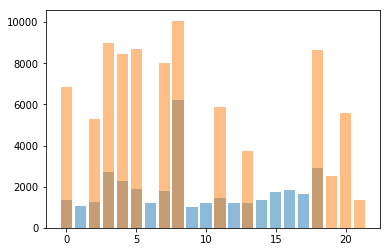

mse= 18423.573540439975
cos 0.20098532151851967
pccs (0.5479496010477127, 0.008290270003614693)
n= 2


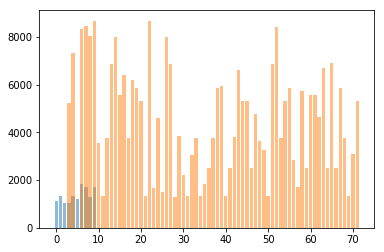

mse= 40291.618681805274
cos 0.618138294997815
pccs (0.1392581337315295, 0.2433481402534057)


In [5]:
show_result(generator, False, useavg=False, avgbase=1, limit=0.5, cut=1000, bigest_num=10)

generatoring data
aprioriing data
total_data_long: 147577
time: 2.57s
time: 4.94s
showing data
n=1


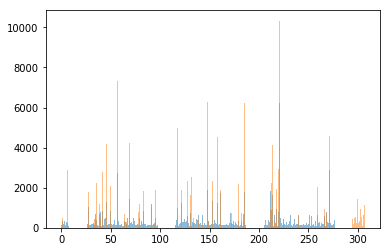

mse= 15524.718161692985
cos 0.16192662632791577
pccs (0.8262179367281828, 3.0149661947899614e-78)
n= 2


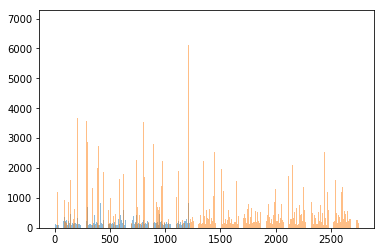

mse= 46044.44033756953
cos 0.44703632824266115
pccs (0.3746221699022331, 1.8740163498095024e-92)


In [28]:
show_result(generator, False, useavg=False, avgbase=1, limit=0.5, bigest_num=30)